# Results Visualizer
This notebook contains a set of visualizations and graphs of the processed results, based on the different hypotheses and conducted experiments. The format is as follows:
- Import of required packages and initialization of parameters that are used throughout the notebook
- A section is dedicated for each of the hypotheses of the thesis that contains more information about the hypothesis, the experiments and the respective results, along with visualizations and graphs.

In [1]:
# Imports
import os
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt

## Experiment metadata
In the output directory of each experiment, there is `metadata.csv` file that stores the configuration of the individual runs for each experiment:
- **dataset_name**: the name of the dataset
- **dataset_iter**: specific train/test split of the dataset used
- **search_type**: `'random', 'ue' or 'smac'`
- **num_classifiers**: list of PyOD classifiers used
- **validation_strategy**: `stratified` or `balanced`
- **validation_size**: `20`, `50`, `100`, `200` or `400`
- **total_budget**: total budget in seconds
- **per_run_budget**: budget per individual run in seconds

From these values, the aggregated experiment parameters are calculated and passed later on to the plotting function for each hypothesis.

In [2]:
# Output directories
results_dirname = '../results/results'
results_path = os.path.join(Path.cwd(), results_dirname)
results_processed_path = os.path.join(results_path, 'processed')
# Import metadata
metadata_filepath = os.path.join(results_path, 'metadata.csv')
metadata_df = pd.read_csv(metadata_filepath)
# Remove individual ue (random search) runs
metadata_df = metadata_df[metadata_df['total_budget'] != 30]
# Extract experiment parameters
total_budget = metadata_df.total_budget[0]
dataset_list = list(metadata_df.dataset_name.unique())
validation_strategy_list = list(metadata_df.validation_strategy.unique())
validation_size_list = list(metadata_df.validation_size.unique())
# Print the parameters
print('Total budget:', total_budget)
print('Dataset list:', dataset_list)
print('Validation strategy list:', validation_strategy_list)
print('Validation size list:', validation_size_list)

Total budget: 600
Dataset list: ['ALOI', 'Annthyroid', 'Cardiotocography', 'KDDCup99', 'SpamBase', 'Waveform']
Validation strategy list: ['stratified', 'balanced']
Validation size list: [20, 50, 100, 200]


## Performance Summary per Dataset
This section parses the processed results for each dataset and prints the best optimization and test scores along with the parameters that achieved them:
 - Search algorithm
 - Validation set split strategy
 - Validation set size

In [43]:
for dataset in dataset_list:
    best_opt_score = 0.0
    best_test_score = 0.0
    best_opt_params = None
    best_test_params = None
    for filename in os.listdir(results_processed_path):
        if dataset in filename:
            # import performance data as DataFrame
            df = pd.read_csv(
                os.path.join(
                    results_processed_path, filename),
            )
            # optimization score
            if df['single_best_optimization_score'].iloc[-1] > best_opt_score:
                best_opt_score = df['single_best_optimization_score'].iloc[-1]
                best_opt_params = filename.split('.')[0].split('_')[1:]
            # test score
            if df['single_best_test_score'].iloc[-1] > best_test_score:
                best_test_score = df['single_best_test_score'].iloc[-1]
                best_test_params = filename.split('.')[0].split('_')[1:]
    print(dataset)
    print('  Opt\t ({}, {})'.format(best_opt_score, best_opt_params))
    print('  Test\t ({}, {})\n'.format(best_test_score, best_test_params))

ALOI
  Opt	 (0.9473684210526316, ['random', 'stratified', '20'])
  Test	 (0.7251194940719964, ['random', 'balanced', '200'])

Annthyroid
  Opt	 (0.9583333333333334, ['random', 'stratified', '20'])
  Test	 (0.7176116427432216, ['ue', 'balanced', '200'])

Cardiotocography
  Opt	 (0.908203125, ['ue', 'stratified', '20'])
  Test	 (0.767396118579371, ['smac', 'balanced', '50'])

KDDCup99
  Opt	 (1.0, ['ue', 'stratified', '50'])
  Test	 (0.9897395833333332, ['ue', 'balanced', '200'])

SpamBase
  Opt	 (0.8287499999999999, ['smac', 'balanced', '20'])
  Test	 (0.6962317284508741, ['ue', 'stratified', '50'])

Waveform
  Opt	 (0.993421052631579, ['ue', 'stratified', '20'])
  Test	 (0.8032087320574162, ['ue', 'stratified', '200'])



## PART 1 - Hypothesis 1: Guided vs. unguided search

**Statement**: *Guided search algorithms such as SMAC are expected to perform better than unguided search algorithms such as Random Search and Uniform Exploration.*

**Comments**:
- The comparison should be done per dataset.
- The comparison should be done for a specified validation strategy (e.g. stratified) and size (e.g. a percentage 30% of the original training set).

## Generic plotting functions
The plotting functions used in the hypotheses sections. were made generic so the generated plots can depend only on the input arguments:
- **output_performance_path**: path to the `performance` directory
- **dataset_list**: list of datasets used in the experiment
- **total_budget**: total budget in seconds
- **validation_strategy_list**: `['stratified', 'balanced']`
- **validation_size_list**: `[20, 50, 100, 200, 400]`
- **eval_type**: `opt` or `test`
- **plot_color_list**: used for consistent coloring

In [3]:
# Plotting function for H1
def plot_h1_results(
    results_processed_path, # str
    dataset_list, # list(str)
    total_budget, # int
    validation_strategy, # int
    validation_size, # int
    eval_type, # str
    color_list # list(str)
):
    # Figure
    width = 4 * len(dataset_list)
    height = 4 * len(dataset_list)
    fig = plt.figure(
        figsize=(width, height)) # grid dimensions
    fig.subplots_adjust(
        wspace=0.4, hspace=0.3) # space between plots
    fig.suptitle(
        'Performance on {} set for {} validation set of size {}'\
        .format(
            eval_type,
            validation_strategy,
            validation_size),
        fontsize=15
    )
    # Plots
    for i, dataset in enumerate(dataset_list):
        for filename in os.listdir(results_processed_path):
            if dataset in filename \
            and validation_strategy in filename \
            and str(validation_size)+'.' in filename:
                # import performance data as DataFrame
                df = pd.read_csv(
                    os.path.join(
                        results_processed_path, filename),
                )
                # x-axis (time)
                x = df.Timestamp
                # score based on eval_type
                if eval_type == 'opt':
                    y = df.single_best_optimization_score
                    dy = df.single_best_optimization_score_std
                elif eval_type == 'test':
                    y = df.single_best_test_score
                    dy = df.single_best_test_score_std
                # plot
                label = filename.split('_')[1]
                ax = plt.subplot(3, 3, i + 1)
                ax.set_ylim([0.5, 1.])
                ax.set_xlabel('seconds')
                ax.set_ylabel('score')
                ax.plot(x, y, label=label, color=color_list[label])
                ax.fill_between(x, y - dy, y + dy, color=color_list[label], alpha=0.5)
                ax.grid()
                handles, labels = ax.get_legend_handles_labels()
                labels, handles = zip(
                    *sorted(zip(labels, handles), key=lambda t: t[0]))
                ax.legend(handles, labels, loc='lower right')
                plt.title(dataset)

In [4]:
# Parameters for H1
validation_size_1 = 100
color_list_1 = {
    'ue': 'orange',
    'random': 'green',
    'smac': 'royalblue',
}

### PART 1.A - Performance for stratified validation sets
The below graphs display the optimization performance, i.e. the performance on the validation set used in Bayesian Optimization, per dataset, for the case of `stratified` validation sets.

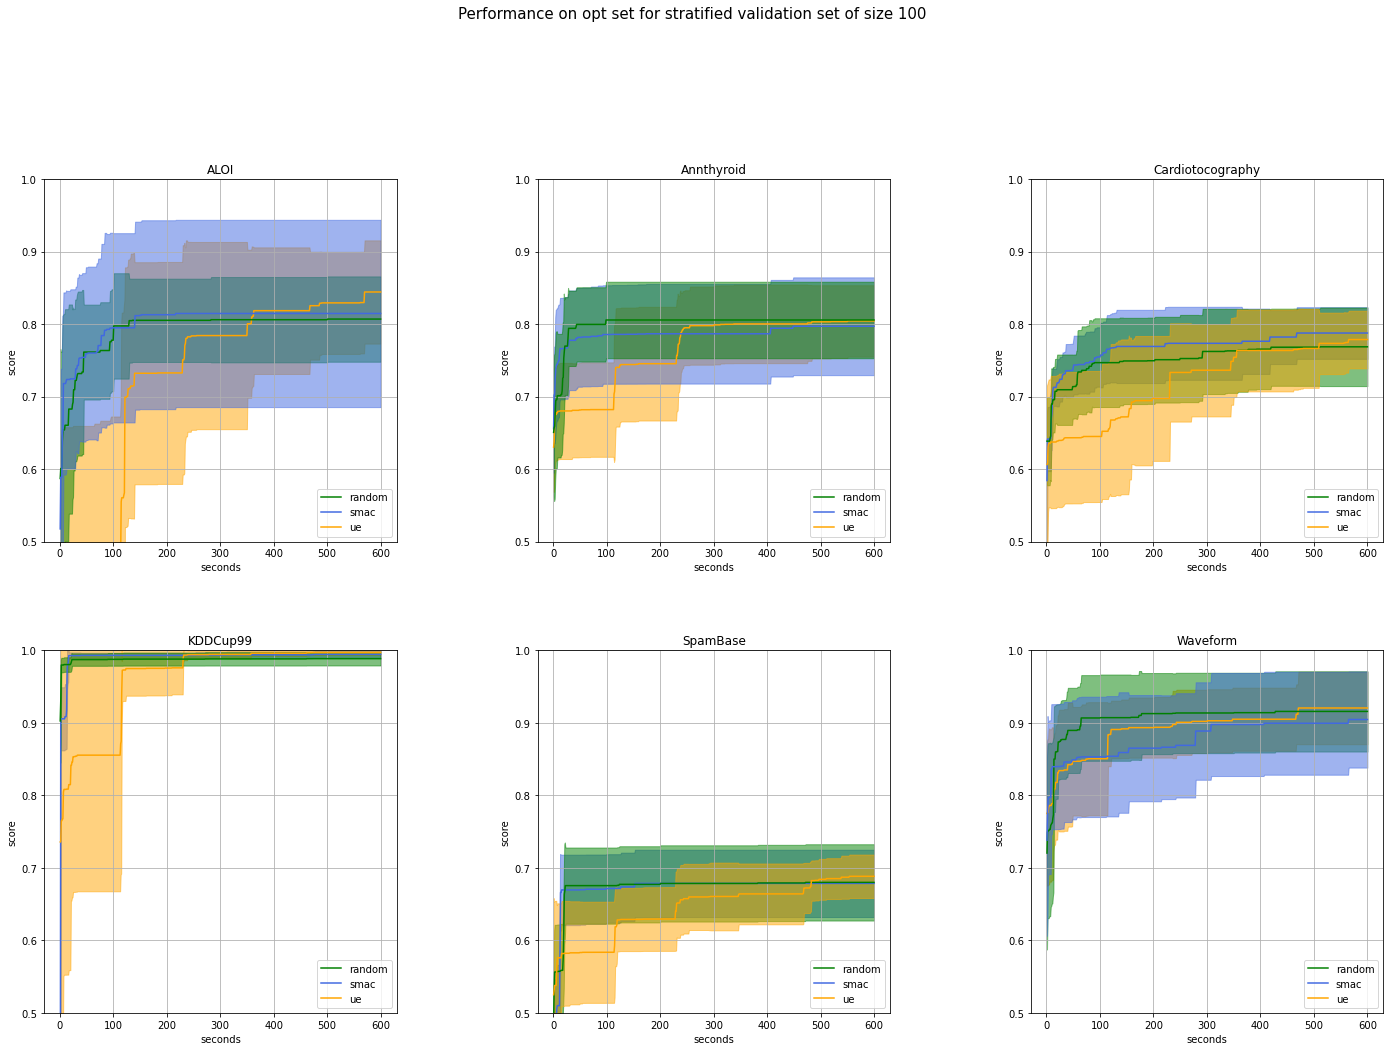

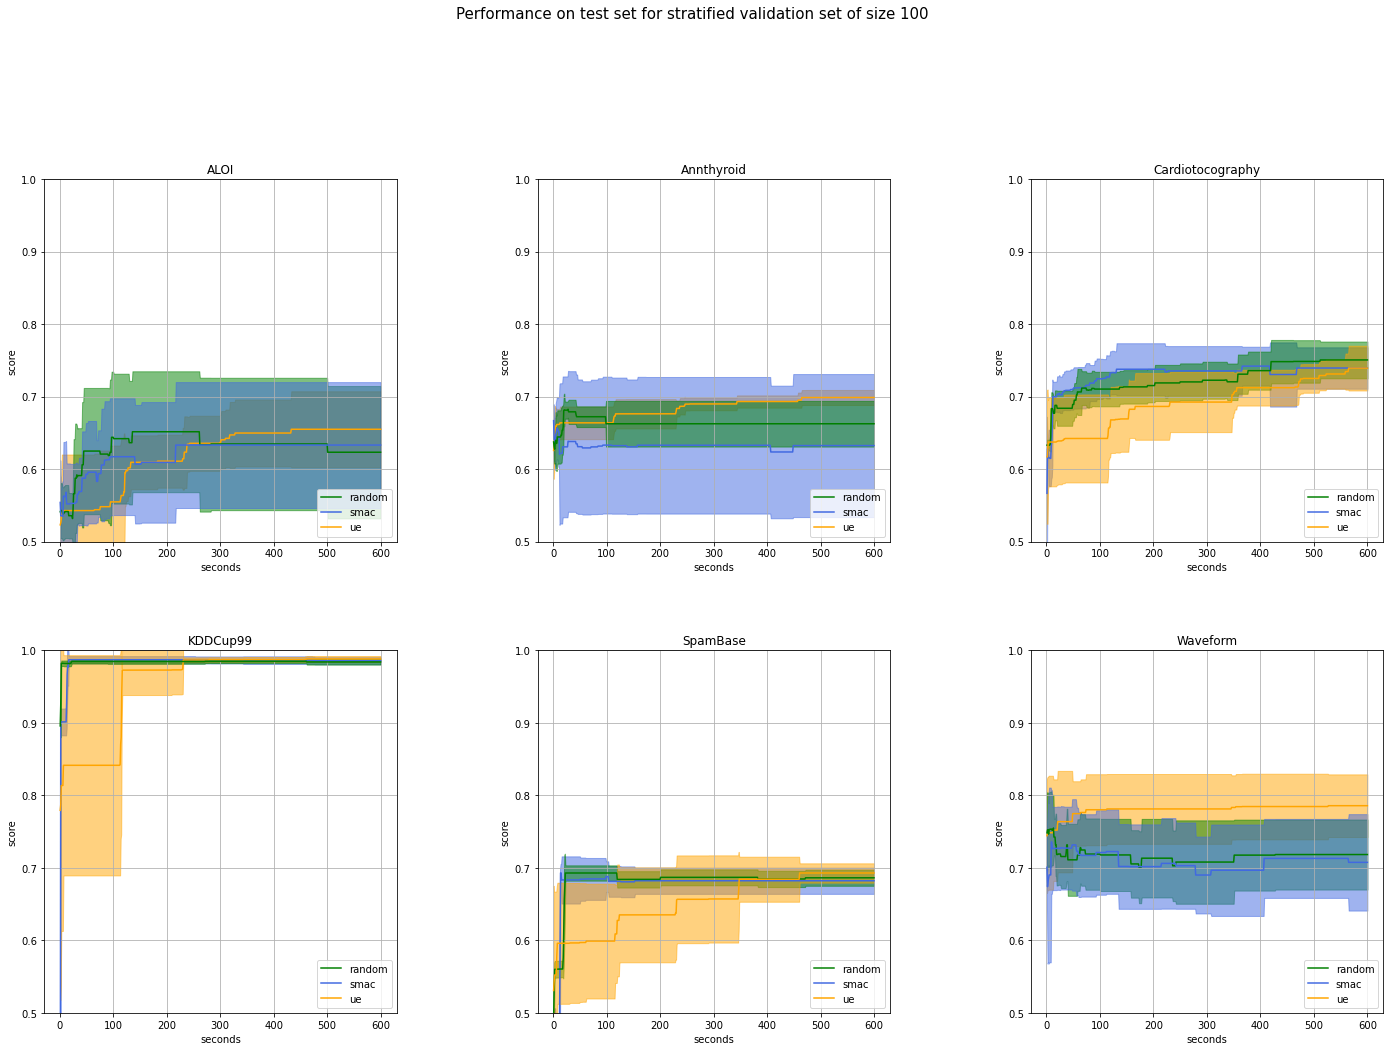

In [5]:
# Parameters for H1.A
validation_strategy_1A = 'stratified'
# Plot optimization performance
plot_h1_results(
    results_processed_path,
    dataset_list,
    total_budget,
    validation_strategy_1A,
    validation_size_1,
    'opt',
    color_list_1
)
# Plot test set performance
plot_h1_results(
    results_processed_path,
    dataset_list,
    total_budget,
    validation_strategy_1A,
    validation_size_1,
    'test',
    color_list_1
)

### Part 1.B - Performance for balanced validation sets
The below graphs display the test set performance per dataset

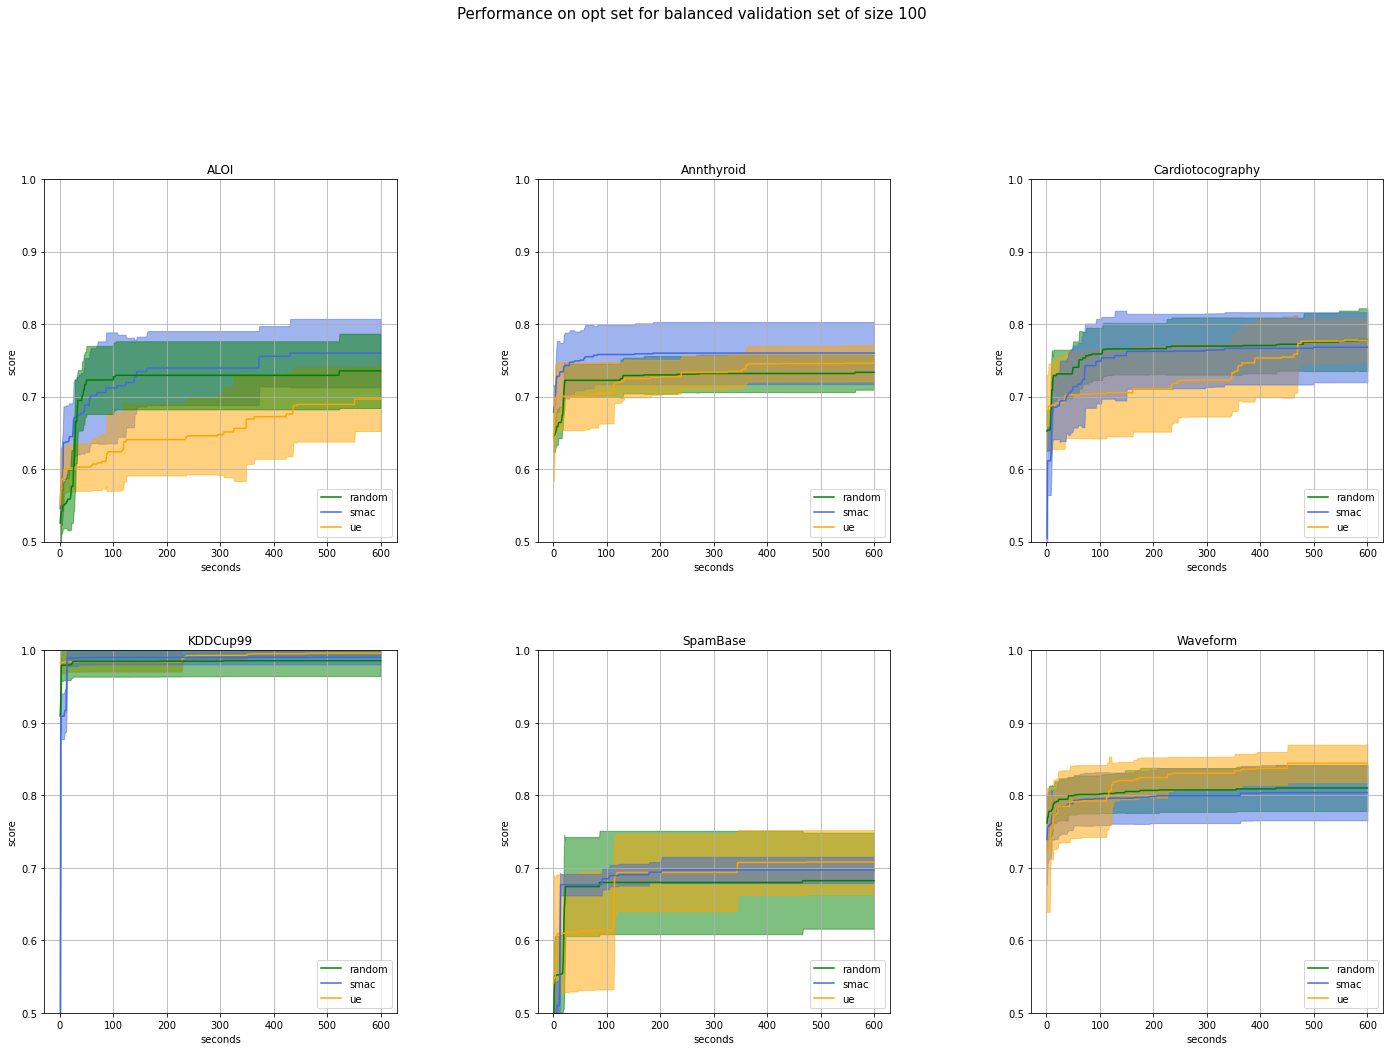

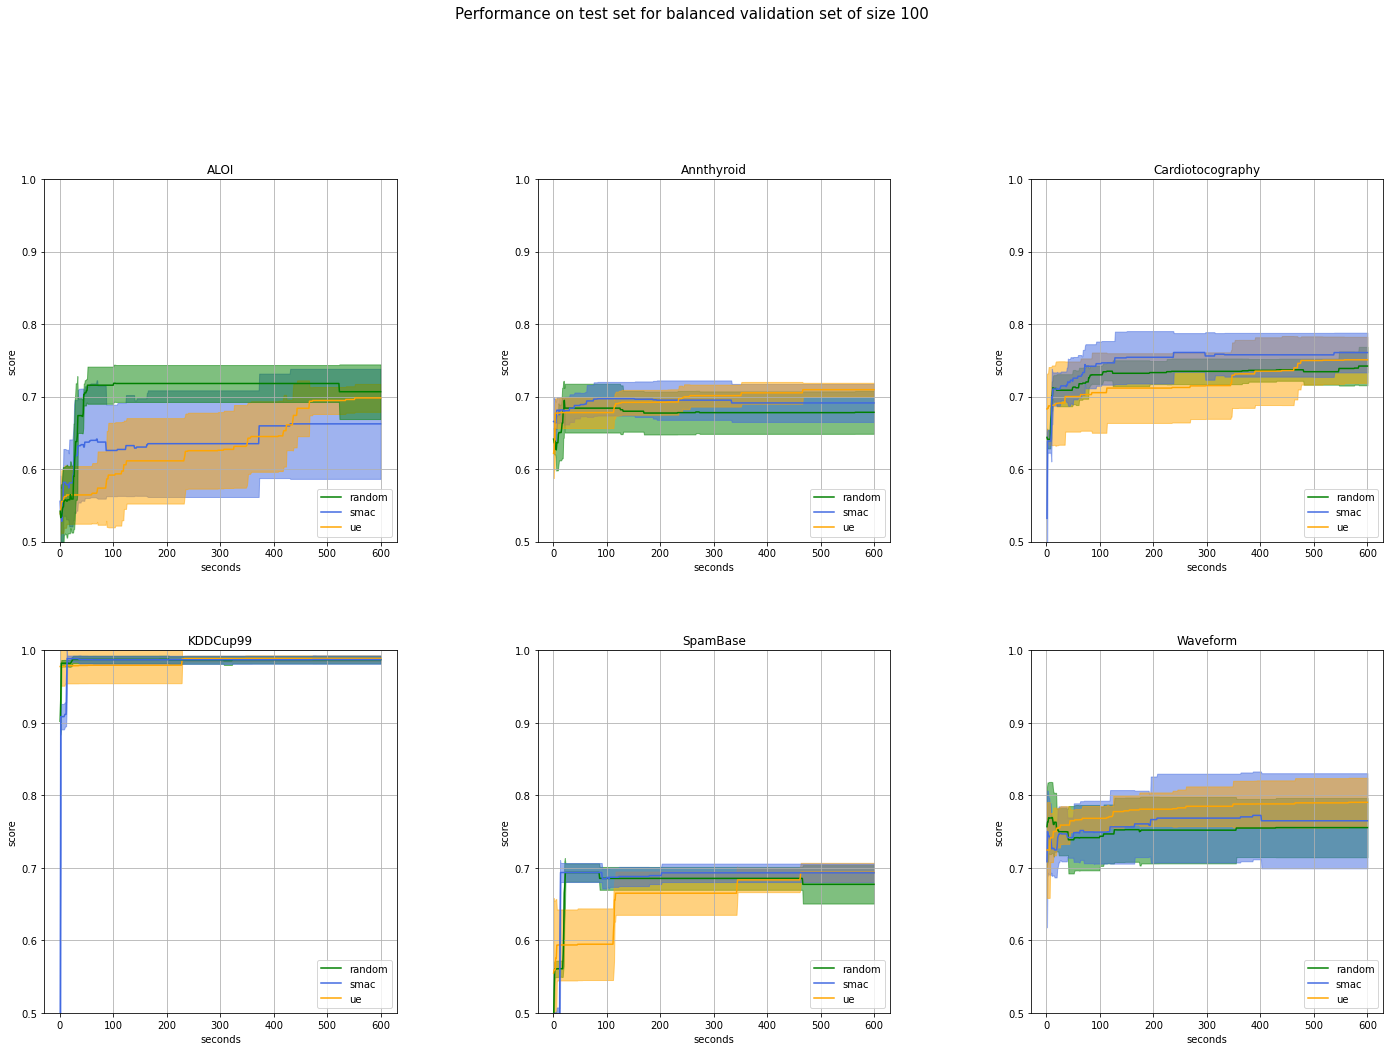

In [6]:
# Parameters for H1.B
validation_strategy_1B = 'balanced'
# Plot optimization performance
plot_h1_results(
    results_processed_path,
    dataset_list,
    total_budget,
    validation_strategy_1B,
    validation_size_1,
    'opt',
    color_list_1
)
# Plot test set performance
plot_h1_results(
    results_processed_path,
    dataset_list,
    total_budget,
    validation_strategy_1B,
    validation_size_1,
    'test',
    color_list_1
)

## PART 2 - Hypothesis 2: Stratified vs. balanced validation sets

**Statement**: *Stratified validation sets are expected to have better performance compared to balanced validation sets.*

**Comments**:
- The expectation of better performance when using stratified validation sets stems from the fact that stratified-sampled validation sets better represent the actual data distribution.
- The comparison should be done per dataset.
- The comparison should be done per search algorithm (uniform exploration, random search, smac)
- The comparison should be done for a specified validation set size (e.g. 30% of the original training set).

In [7]:
# Plotting function for H2
def plot_h2_results(
    results_processed_path, # str
    dataset_list, # list(str)
    search_algorithm, # str
    total_budget, # int
    validation_size, # int
    eval_type, # str
    color_list # list(str)
):
    # Figure
    width = 4 * len(dataset_list)
    height = 4 * len(dataset_list)
    fig = plt.figure(
        figsize=(width, height)) # grid dimensions
    fig.subplots_adjust(
        wspace=0.4, hspace=0.3) # space between plots
    fig.suptitle(
        'Performance on {} set for {} search and validation set of size {}'\
        .format(
            eval_type,
            search_algorithm,
            validation_size),
        fontsize=15
    )
    # Plots
    for i, dataset in enumerate(dataset_list):
        for filename in os.listdir(results_processed_path):
            if dataset in filename and \
            search_algorithm in filename and \
            str(validation_size)+'.' in filename:
                # import performance data as DataFrame
                df = pd.read_csv(
                    os.path.join(
                        results_processed_path, filename)
                )
                # x-axis (time)
                x = df.Timestamp
                # score based on eval_type
                if eval_type == 'opt':
                    y = df.single_best_optimization_score
                elif eval_type == 'test':
                    y = df.single_best_test_score
                # plot
                label = filename.split('_')[2]
                ax = plt.subplot(3, 3, i + 1)
                ax.set_ylim([0.5, 1.])
                ax.set_xlabel('seconds')
                ax.set_ylabel('score')
                ax.plot(x, y, label=label, color=color_list[label])
                ax.grid()
                handles, labels = ax.get_legend_handles_labels()
                labels, handles = zip(
                    *sorted(zip(labels, handles), key=lambda t: t[0]))
                ax.legend(handles, labels, loc='lower right')
                plt.title(dataset)

In [8]:
# Parameters for H2
validation_size_2 = 50
color_list_2 = {
    'stratified': 'orange',
    'balanced': 'green',
}

### Part 2.A - SMAC Search
The below graphs display the test set performance per dataset for the SMAC search

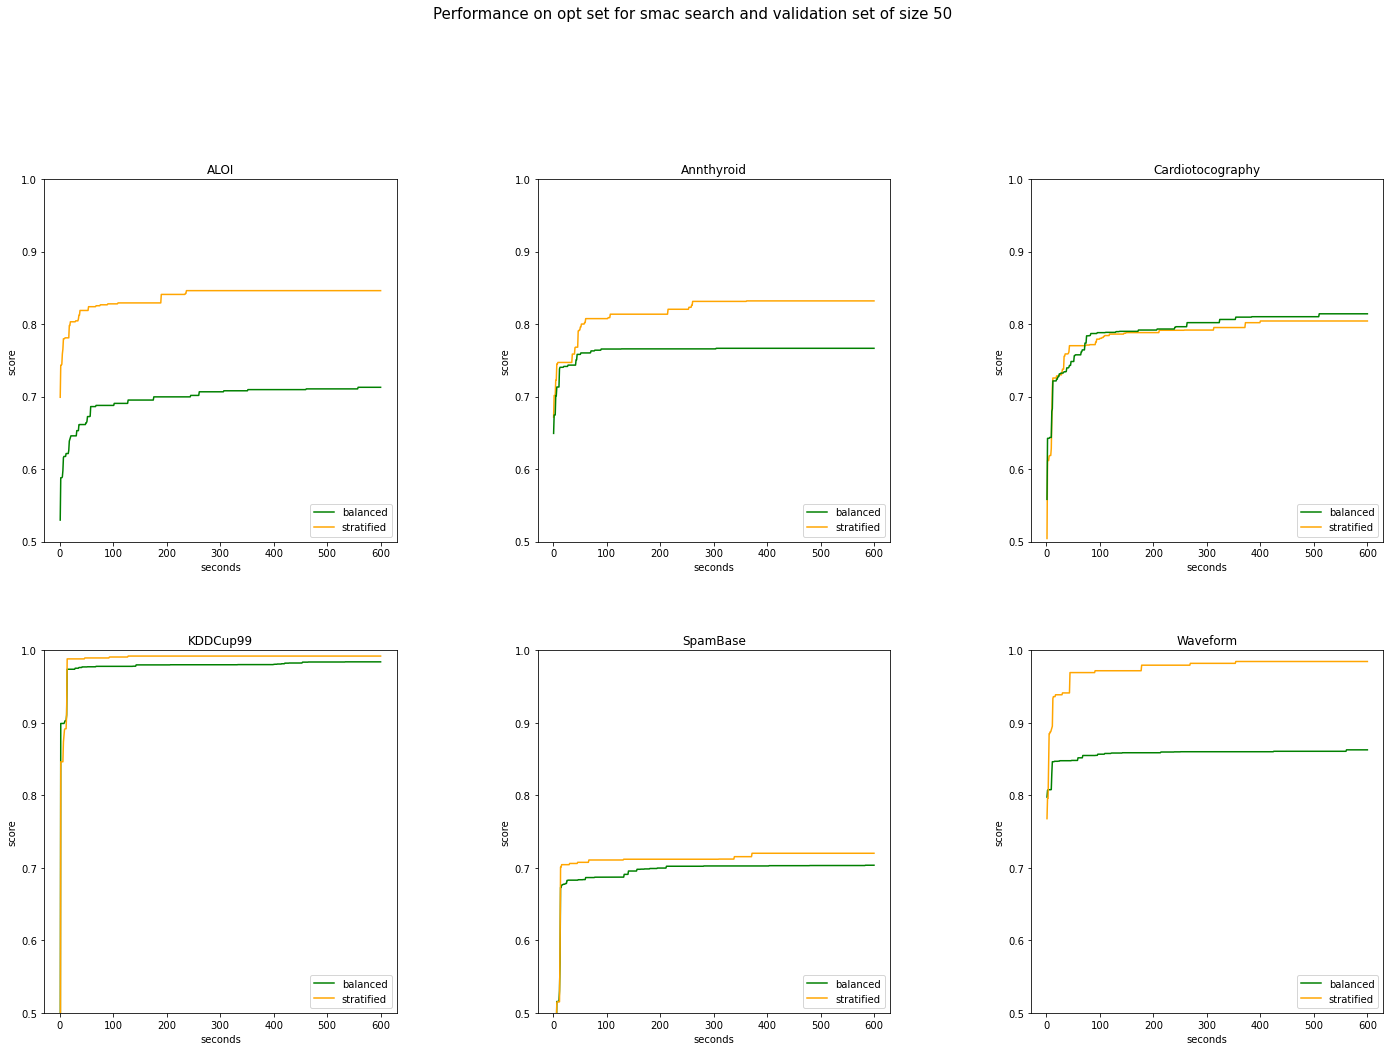

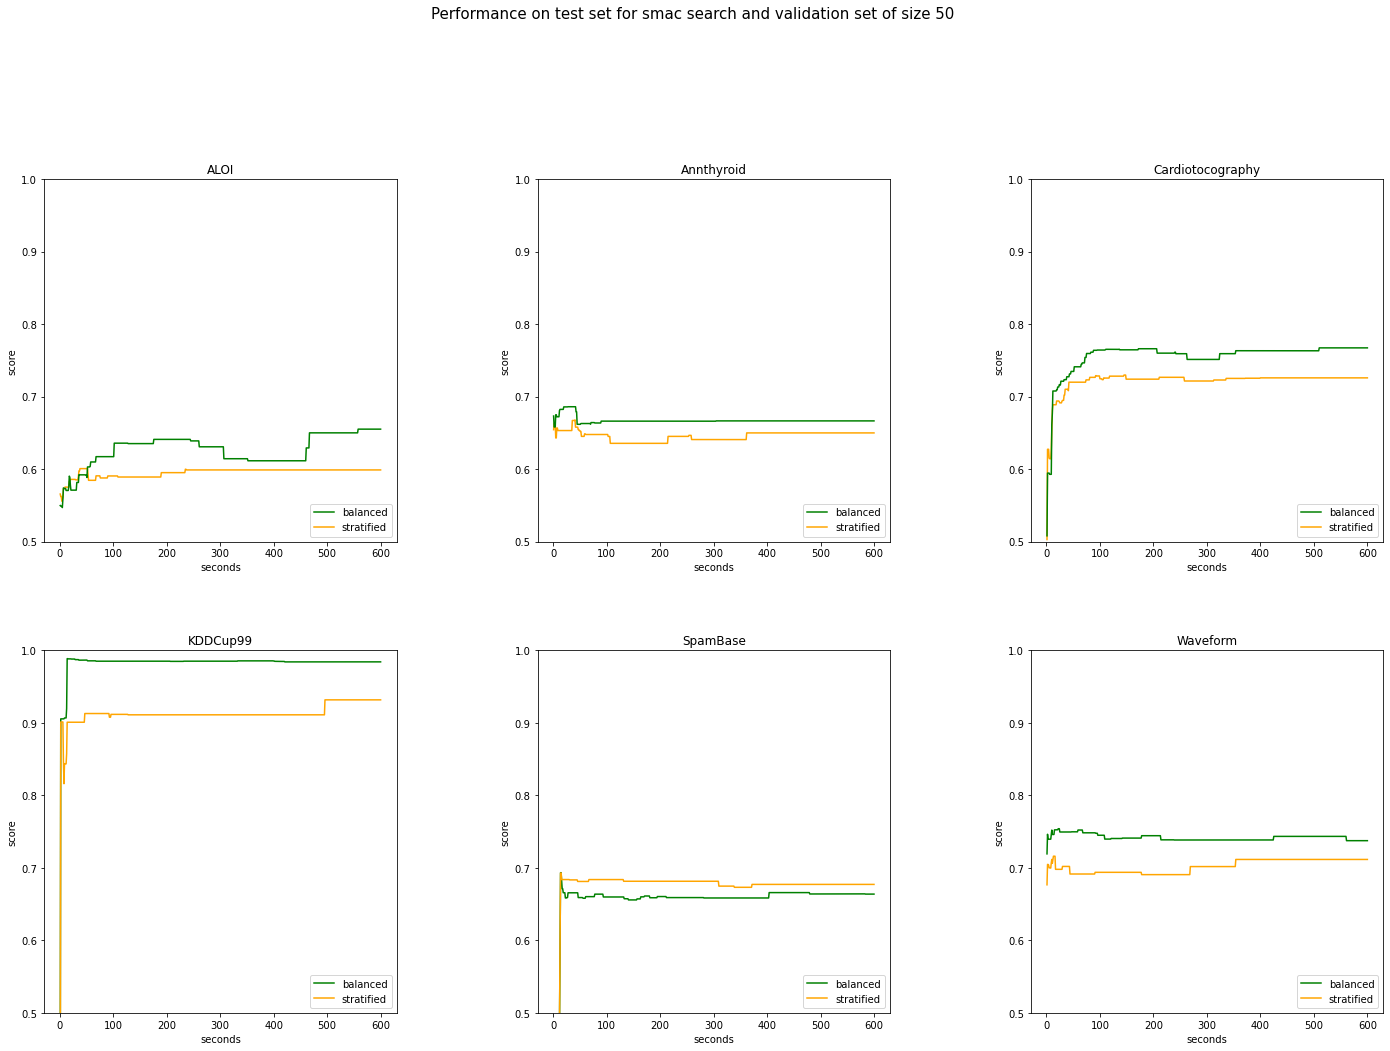

In [9]:
# Parameters for H2.A
search_algorithm_2A = 'smac'
# Plot optimization performance
plot_h2_results(
    results_processed_path,
    dataset_list,
    search_algorithm_2A,
    total_budget,
    validation_size_2,
    'opt',
    color_list_2
)
# Plot test set performance
plot_h2_results(
    results_processed_path,
    dataset_list,
    search_algorithm_2A,
    total_budget,
    validation_size_2,
    'test',
    color_list_2
)

### Part 2.B - Random Search
The below graphs display the test set performance per dataset for *Random Search*

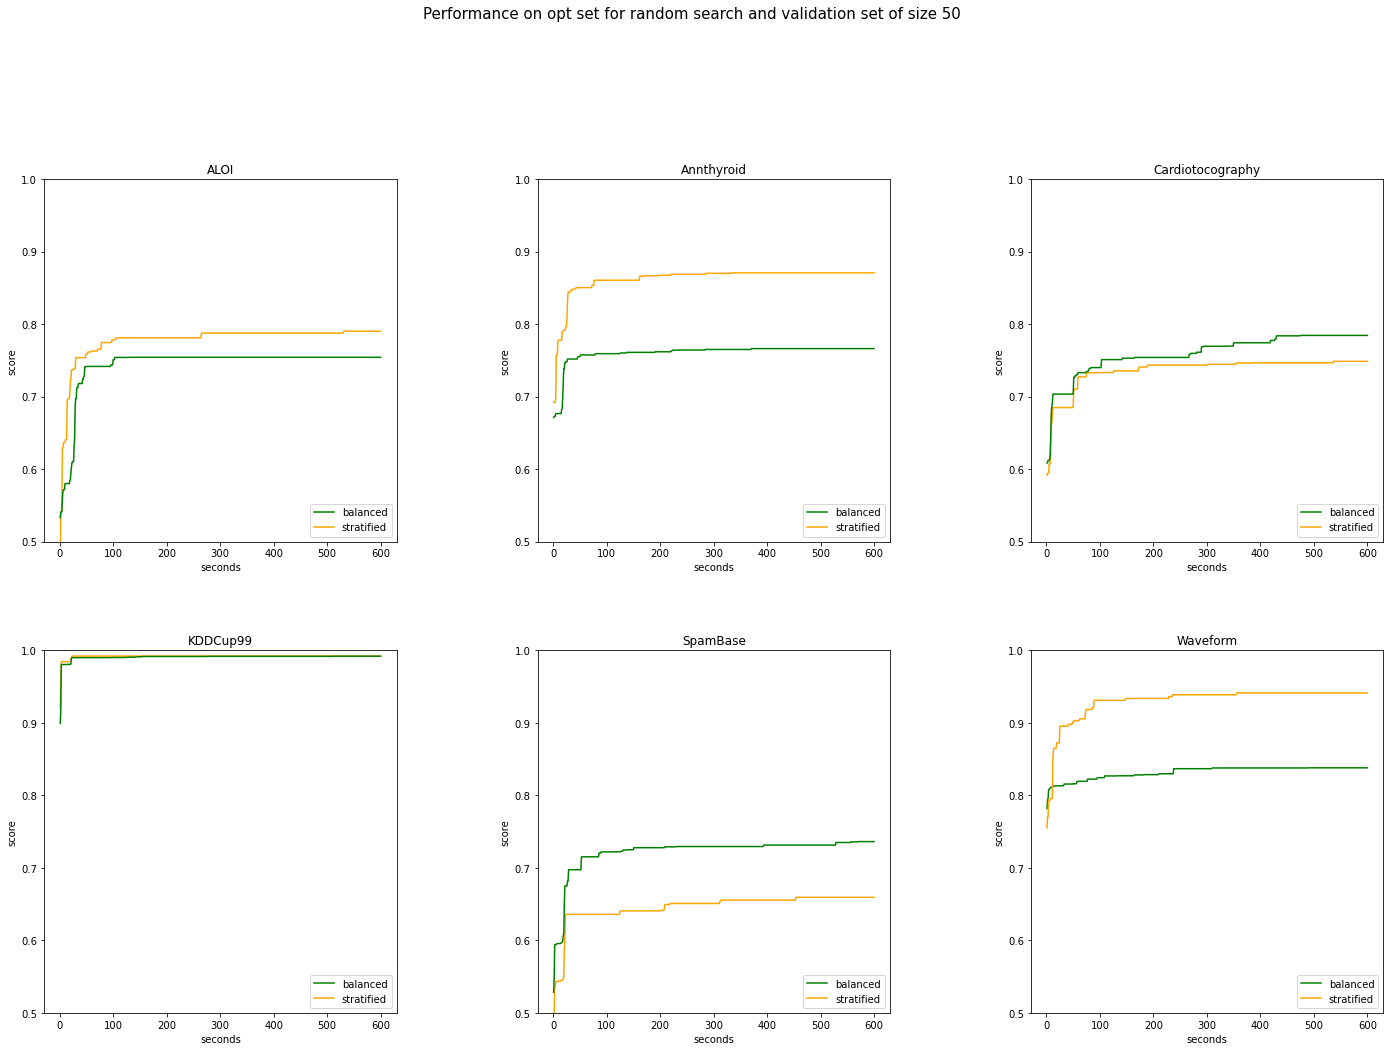

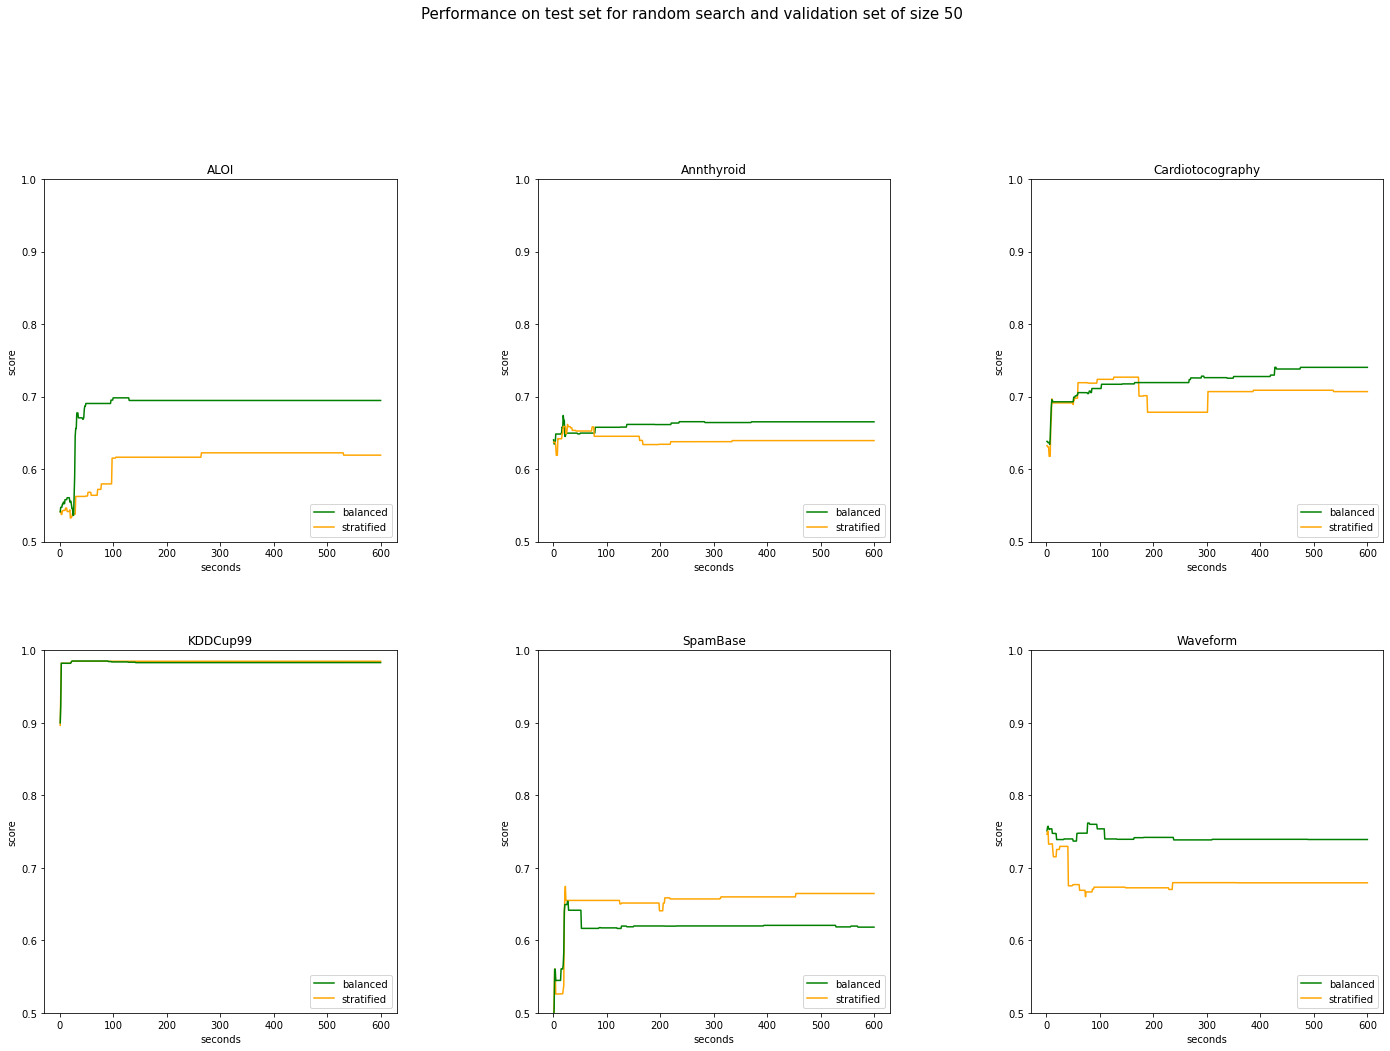

In [10]:
# Parameters for H2.B
search_algorithm_2B = 'random'
# Plot optimization performance
plot_h2_results(
    results_processed_path,
    dataset_list,
    search_algorithm_2B,
    total_budget,
    validation_size_2,
    'opt',
    color_list_2
)
# Plot test set performance
plot_h2_results(
    results_processed_path,
    dataset_list,
    search_algorithm_2B,
    total_budget,
    validation_size_2,
    'test',
    color_list_2
)

### Part 2.C - Uniform Exploration Search
The below graphs display the test set performance per dataset for the *Uniform Exploration Search*

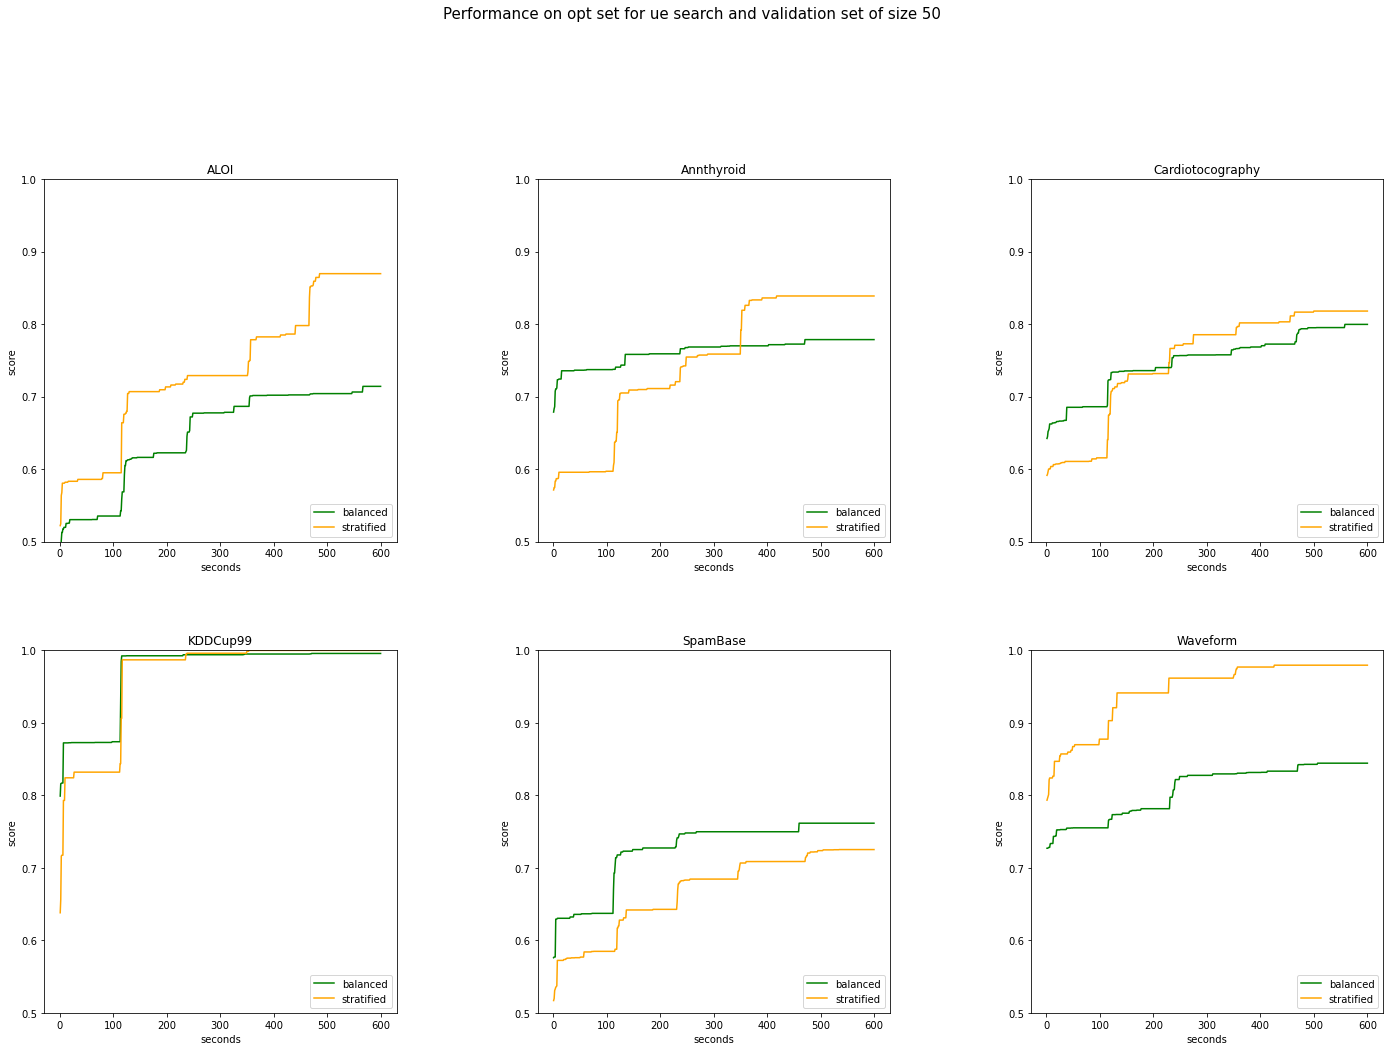

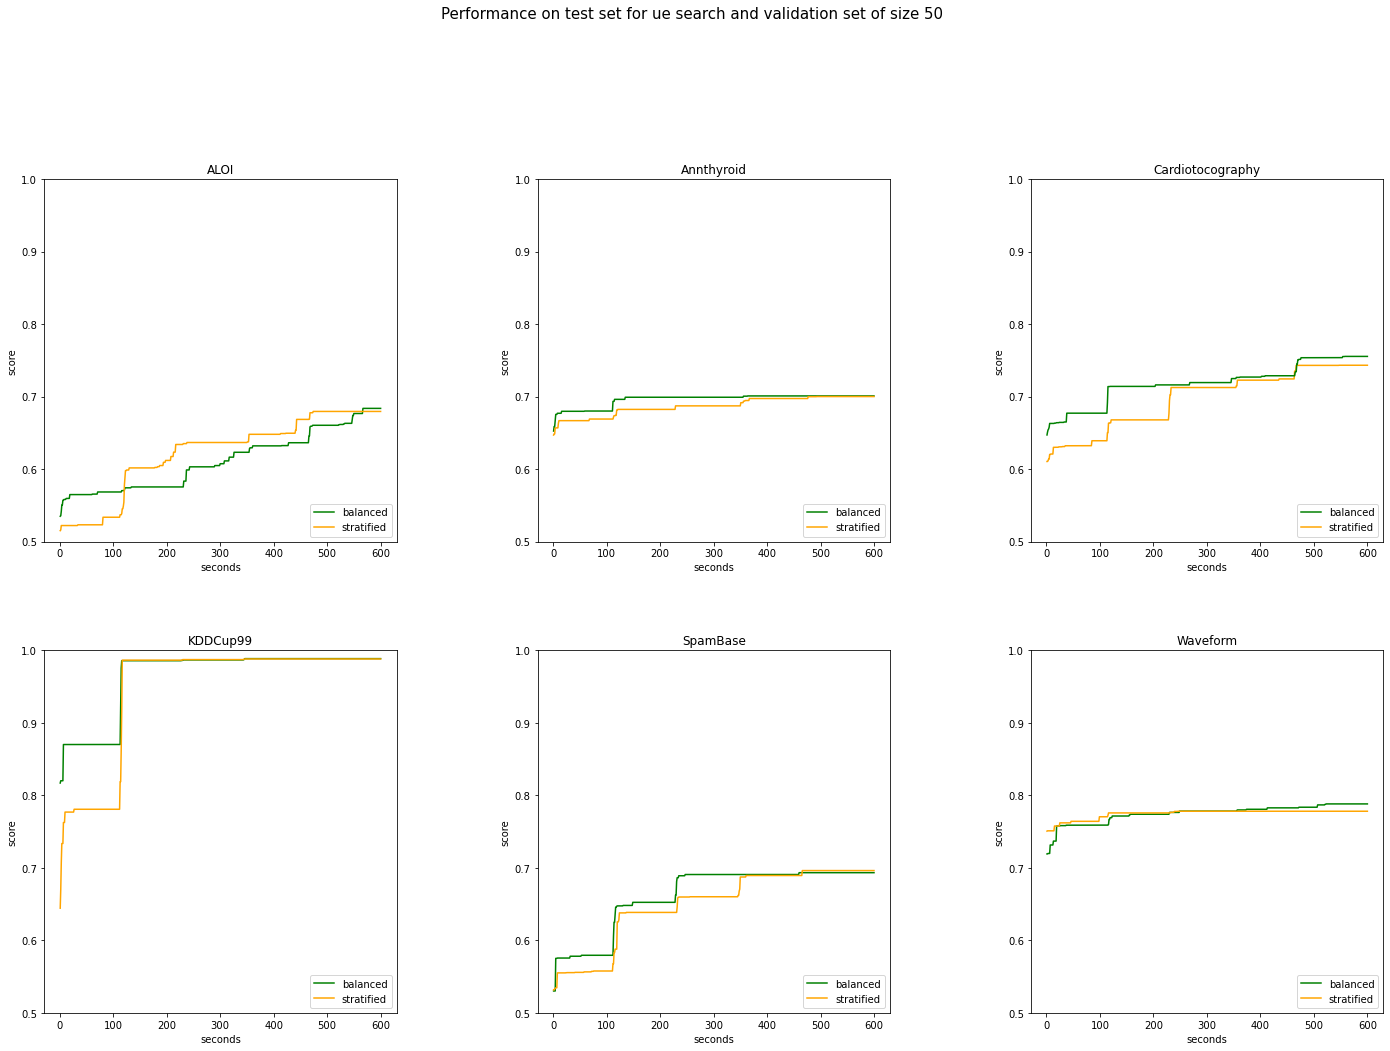

In [11]:
# Parameters for H2.C
search_algorithm_2C = 'ue'
# Plot optimization performance
plot_h2_results(
    results_processed_path,
    dataset_list,
    search_algorithm_2C,
    total_budget,
    validation_size_2,
    'opt',
    color_list_2
)
# Plot test set performance
plot_h2_results(
    results_processed_path,
    dataset_list,
    search_algorithm_2C,
    total_budget,
    validation_size_2,
    'test',
    color_list_2
)

## Hypothesis 3 - Larger vs. smaller validation sets

**Statement**: *Larger validation sets are expected to have better performance compared to smaller validation sets.*

**Comments**:
- Validation set sizes to compare: 20, 50, 100, 200
- Comparison should be done per dataset
- Comparison should be done per search algorithm

In [12]:
# Plotting function for H3
def plot_h3_results(
    results_processed_path, # str
    dataset_list, # list(str)
    search_algorithm, # str
    total_budget, # int
    validation_strategy, # str
    validation_size_list, # list(int)
    eval_type, # str
    color_list # list(str) 
):
    # Figure
    width = 4 * len(dataset_list)
    height = 4 * len(dataset_list)
    fig = plt.figure(
        figsize=(width, height)) # grid dimensions
    fig.subplots_adjust(
        wspace=0.4, hspace=0.3) # space between plots
    fig.suptitle(
        'Performance on {} set for {} search and {} validation set'\
        .format(
            eval_type,
            search_algorithm,
            validation_strategy),
        fontsize=15
    )
    # Plots
    for i, dataset in enumerate(dataset_list):
        for filename in os.listdir(results_processed_path):
            if (dataset in filename and \
                search_algorithm in filename and \
                validation_strategy in filename \
                and any(str(size) in filename for size in validation_size_list)):
                # import performance data as DataFrame
                df = pd.read_csv(
                    os.path.join(
                        results_processed_path,
                        filename
                    )
                )
                # x-axis (seconds)
                x = df.Timestamp
                # score based on eval_type
                if eval_type == 'opt':
                    y = df.single_best_optimization_score
                elif eval_type == 'test':
                    y = df.single_best_test_score
                # plot
                label = int(filename.split('_')[3].split('.')[0])
                ax = plt.subplot(3, 3, i + 1)
                ax.set_ylim([0.2, 1.])
                ax.set_xlabel('seconds')
                ax.set_ylabel('score')
                ax.plot(x, y, label=label, color=color_list[label])
                ax.grid()
                handles, labels = ax.get_legend_handles_labels()
                labels = [int(l) for l in labels] # convert to integer for sorting
                labels, handles = zip(
                *sorted(zip(labels, handles), key=lambda t: t[0]))
                ax.legend(handles, labels, loc='lower right')
                plt.title(dataset)

In [13]:
# Parameters for H3
validation_strategy_3 = 'stratified'
color_list_3 = {
    20: 'red',
    50: 'orange',
    100: 'green',
    200: 'royalblue',
}

### Part 3.A - SMAC Search
The below graphs display the test set performance per dataset for the **SMAC Search**

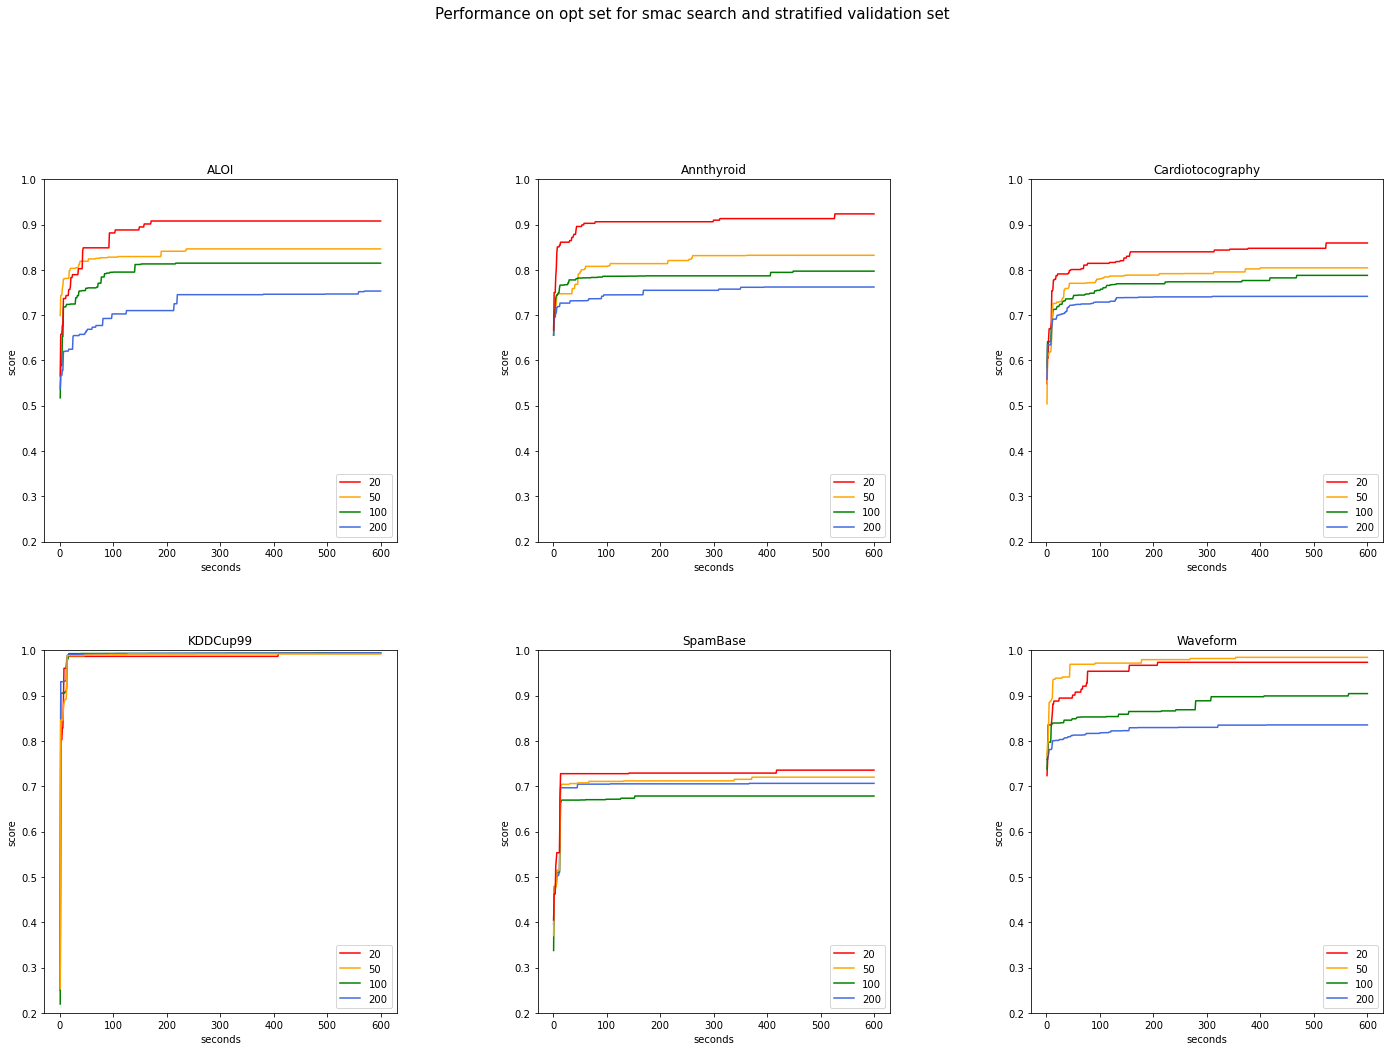

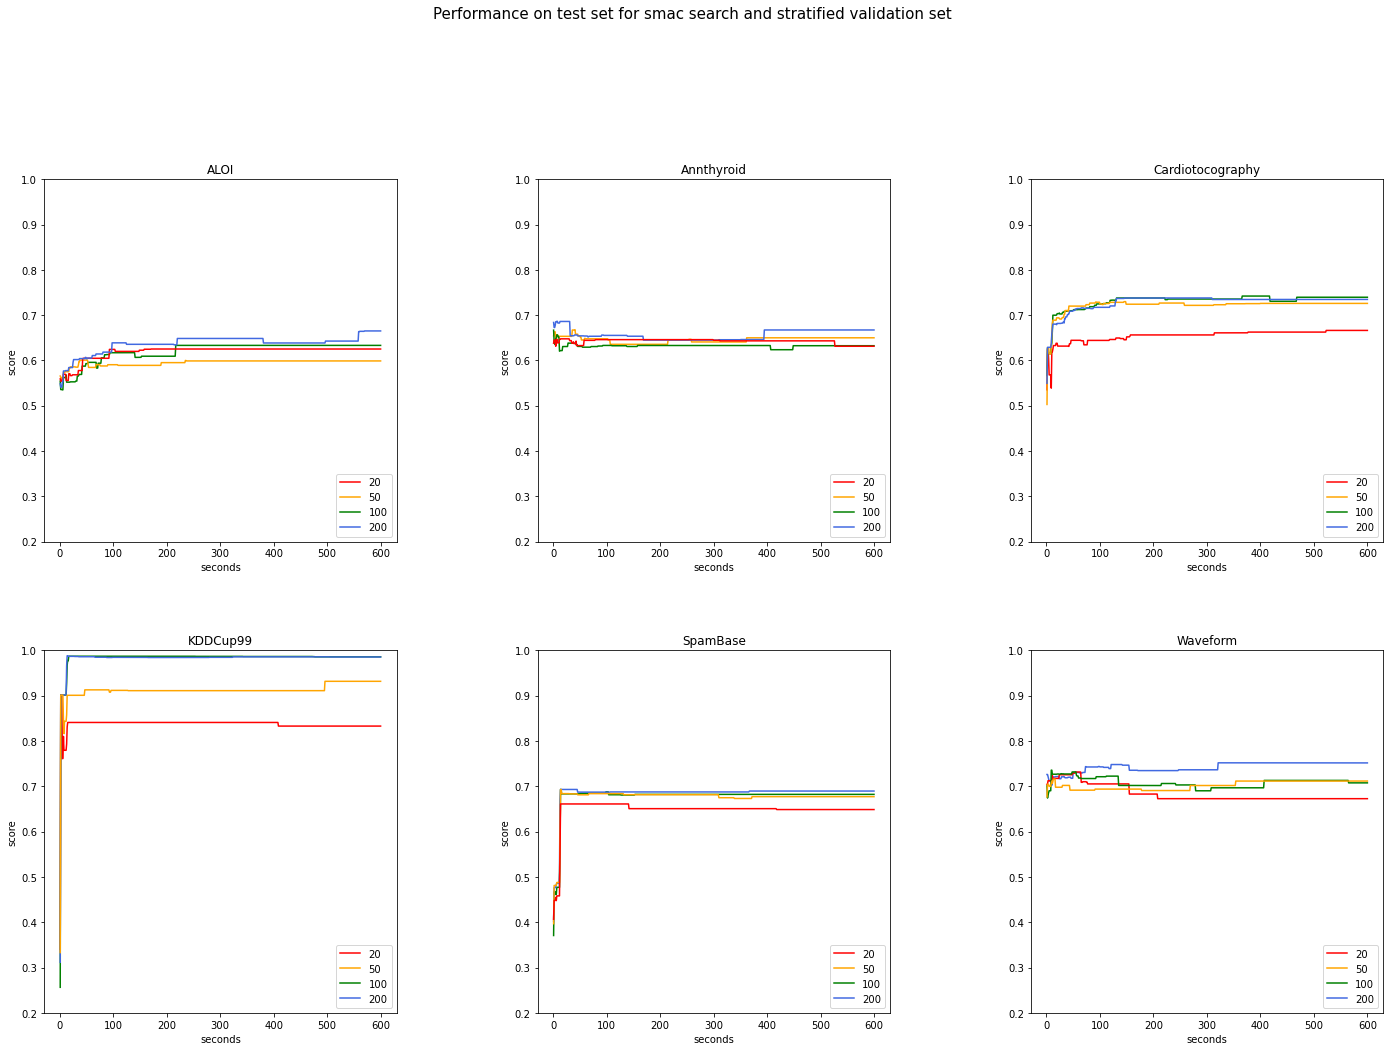

In [14]:
# Parameters for H3.A
search_algorithm_3A = 'smac'
# Plot optimization performance
plot_h3_results(
    results_processed_path,
    dataset_list,
    search_algorithm_3A,
    total_budget,
    validation_strategy_3,
    validation_size_list,
    'opt',
    color_list_3
)
# Plot test set performance
plot_h3_results(
    results_processed_path,
    dataset_list,
    search_algorithm_3A,
    total_budget,
    validation_strategy_3,
    validation_size_list,
    'test',
    color_list_3
)

### Part 3.B - Random Search
The below graphs display the test set performance per dataset for **Random Search**

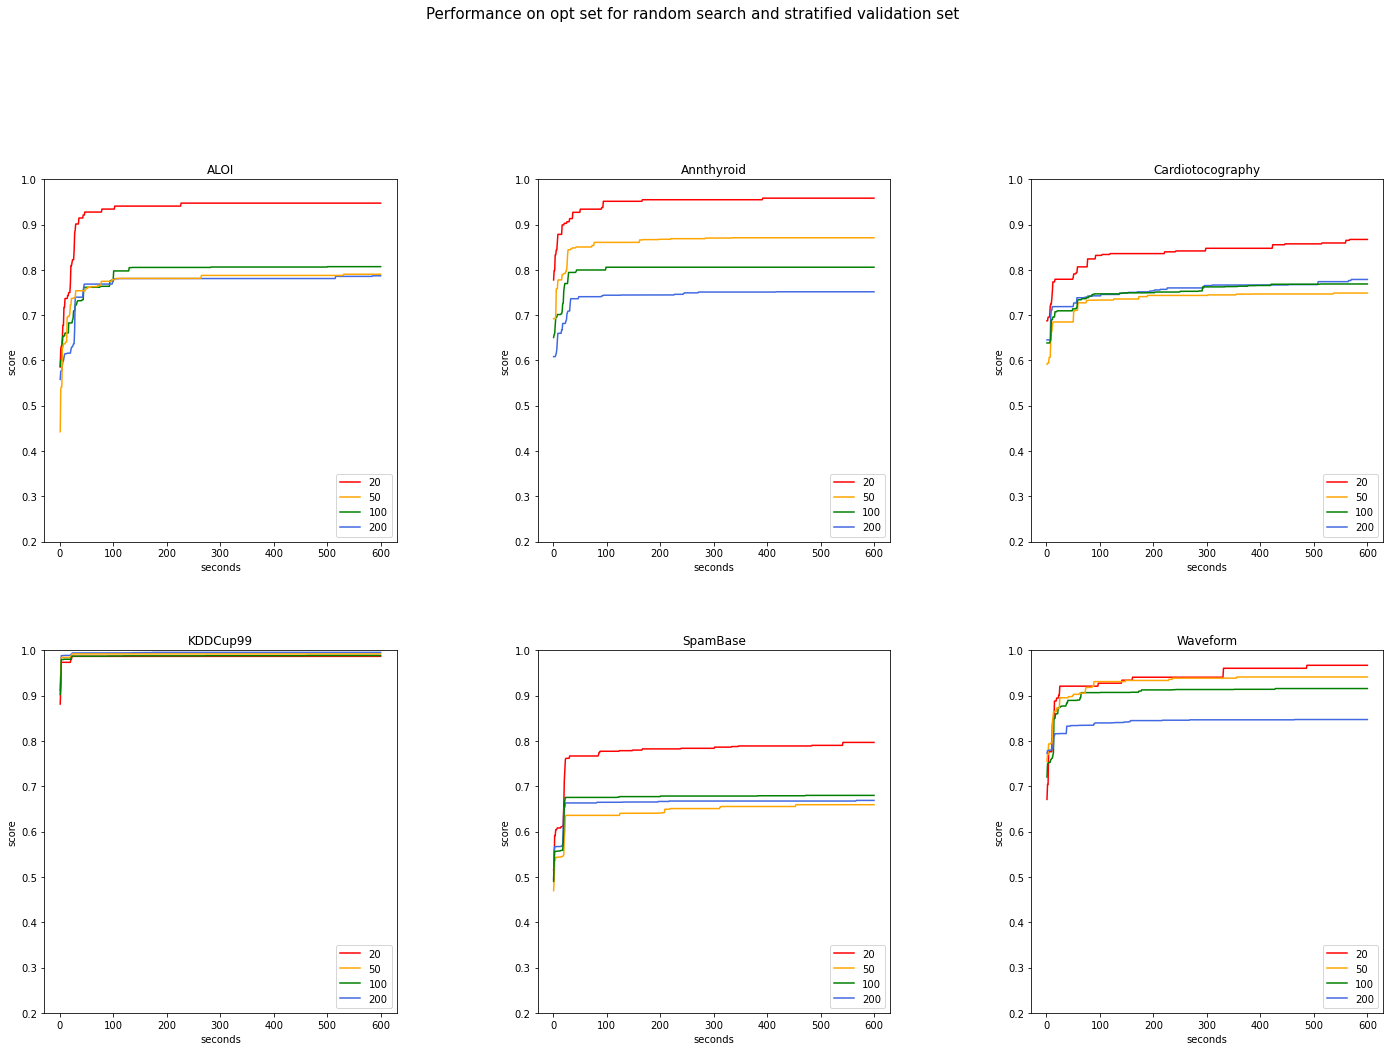

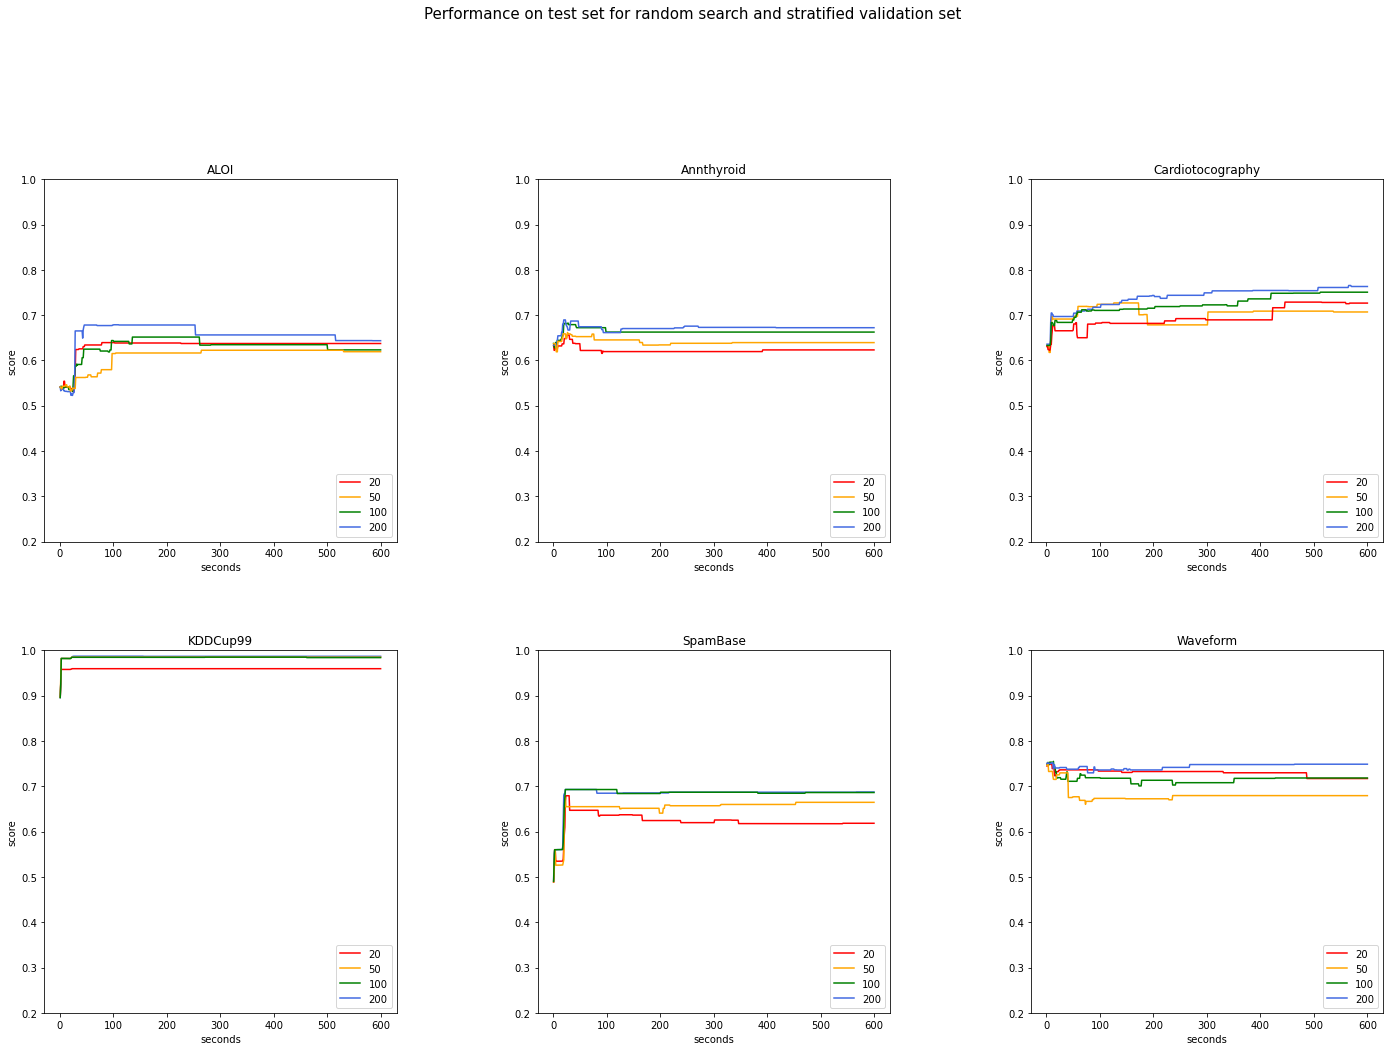

In [15]:
# Parameters for H3.B
search_algorithm_3B = 'random'
# Plot optimization performance
plot_h3_results(
    results_processed_path,
    dataset_list,
    search_algorithm_3B,
    total_budget,
    validation_strategy_3,
    validation_size_list,
    'opt',
    color_list_3
)
# Plot test set performance
plot_h3_results(
    results_processed_path,
    dataset_list,
    search_algorithm_3B,
    total_budget,
    validation_strategy_3,
    validation_size_list,
    'test',
    color_list_3
)

### Part 3.C - Uniform Exploration Search
The below graphs display the test set performance per dataset for the **Uniform Exploration Search**

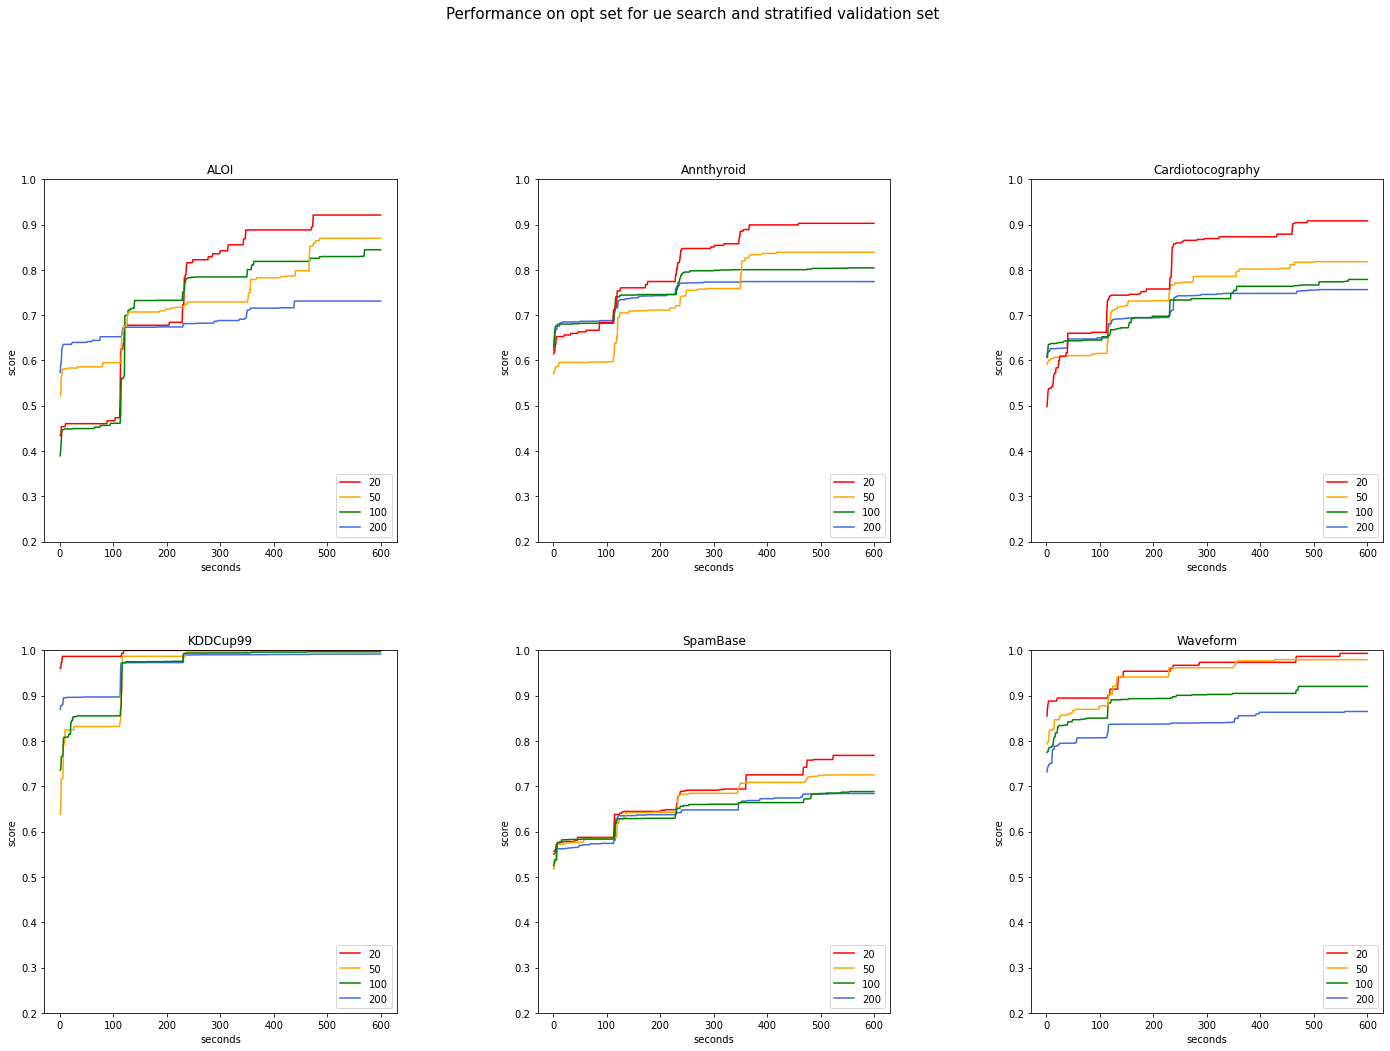

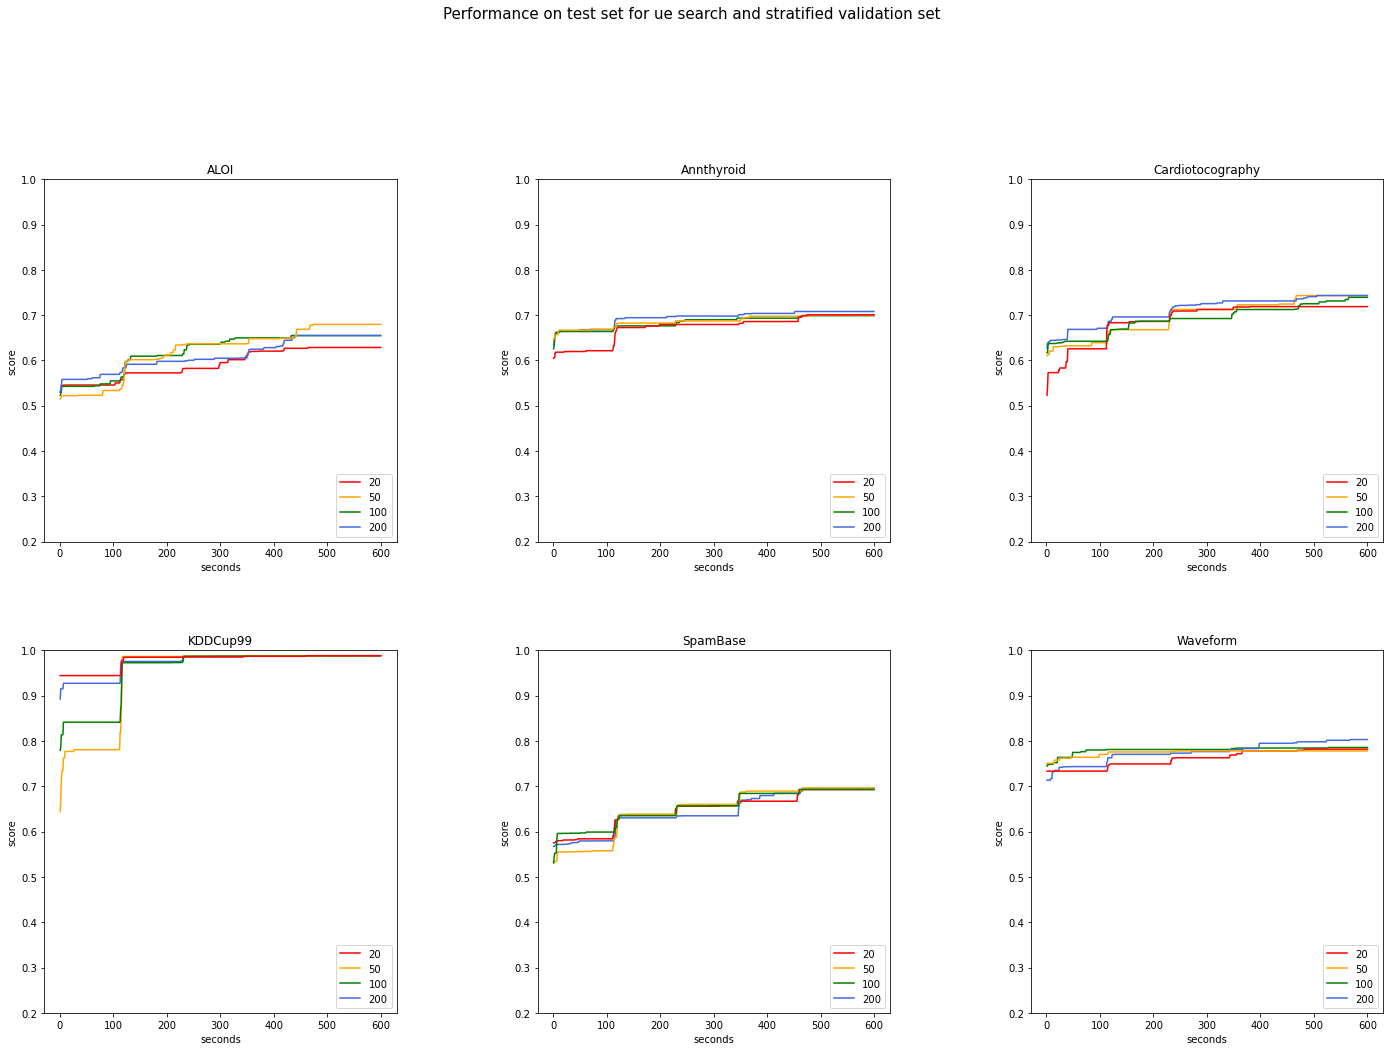

In [16]:
# Parameters for H3.C
search_algorithm_3C = 'ue'
# Plot optimization performance
plot_h3_results(
    results_processed_path,
    dataset_list,
    search_algorithm_3C,
    total_budget,
    validation_strategy_3,
    validation_size_list,
    'opt',
    color_list_3
)
# Plot test set performance
plot_h3_results(
    results_processed_path,
    dataset_list,
    search_algorithm_3C,
    total_budget,
    validation_strategy_3,
    validation_size_list,
    'test',
    color_list_3
)